# Dataset Preparation and Classification Model Training

This notebook is designed to prepare the TACO dataset for classification tasks and train a model to predict object categories. It includes:
1. Data augmentation and preprocessing for the training dataset.
2. Removing low-quality data (images with IoU = 0).
3. Creating and training a classification model using TensorFlow and ResNet.
4. Evaluating the trained model on validation and test datasets.

This pipeline ensures a clean dataset and leverages robust architectures to achieve high classification accuracy.


In [1]:
import os
import json
import logging
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from ultralytics import YOLO
import cv2
import json


In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set paths
train_dir = r"C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train"
val_dir = r"C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val"
test_dir = r"C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test"
train_ann_path = r"C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train_iou_results.json"
val_ann_path = r"C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val_iou_results.json"
test_ann_path = r"C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test_iou_results.json"

## Data Augmentation

Data augmentation techniques are applied to the training dataset using `ImageDataGenerator`. Augmentations include:
- Rescaling pixel values.
- Random transformations such as rotation, zoom, shearing, and flipping.

These augmentations improve the generalization capability of the model by exposing it to a diverse set of transformations.


In [3]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=30,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shearing transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Horizontal flip
    fill_mode="nearest"  # Fill pixels when transforming
)

## Discard Low-Quality Images

Images with an IoU of 0 are considered low-quality and removed from the dataset. This step ensures that only valid samples are used for training, validation, and testing, improving the reliability of the model.


In [4]:
# Function to discard images with IoU == 0
def discard_images_with_zero_iou(iou_results_path, dataset_dir):
    # Load IoU results
    with open(iou_results_path, 'r') as f:
        iou_results = json.load(f)

    # Identify images with IoU == 0
    images_to_discard = [f"{result['image_id']}.jpg" for result in iou_results if result["iou"] == 0]
    total = 0
    # Iterate through class subdirectories and remove the images
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for image_name in os.listdir(class_dir):
            if image_name in images_to_discard:
                image_path = os.path.join(class_dir, image_name)
                os.remove(image_path)  # Remove the image
                total =+ 1
    print(total)

    print(f"Finished discarding images with IoU == 0 in {dataset_dir}.")

# Discard images with IoU == 0 for validation and test sets
discard_images_with_zero_iou(train_ann_path, train_dir)
discard_images_with_zero_iou(val_ann_path, val_dir)
discard_images_with_zero_iou(test_ann_path, test_dir)

print("Completed discarding images with IoU == 0 for all datasets.")

1
Finished discarding images with IoU == 0 in C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train.
1
Finished discarding images with IoU == 0 in C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val.
1
Finished discarding images with IoU == 0 in C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test.
Completed discarding images with IoU == 0 for all datasets.


In [5]:
# Rescale only for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load datasets
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode="categorical"  # Multi-class classification
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Shuffle should be False for test set
)

# Get the number of classes
num_classes = len(train_data.class_indices)
print(f"Number of classes: {num_classes}")

Found 1045 images belonging to 26 classes.
Found 225 images belonging to 22 classes.
Found 225 images belonging to 21 classes.
Number of classes: 26


In [6]:
# Class distribution in train, validation, and test sets
print("Training set class distribution:")
print(train_data.class_indices)

print("Validation set class distribution:")
print(val_data.class_indices)

print("Test set class distribution:")
print(test_data.class_indices)


Training set class distribution:
{'Aluminium foil': 0, 'Battery': 1, 'Blister pack': 2, 'Bottle': 3, 'Bottle cap': 4, 'Broken glass': 5, 'Can': 6, 'Carton': 7, 'Cigarette': 8, 'Cup': 9, 'Food waste': 10, 'Lid': 11, 'Other plastic': 12, 'Paper': 13, 'Paper bag': 14, 'Plastic bag & wrapper': 15, 'Plastic container': 16, 'Plastic utensils': 17, 'Pop tab': 18, 'Rope & strings': 19, 'Scrap metal': 20, 'Shoe': 21, 'Squeezable tube': 22, 'Straw': 23, 'Styrofoam piece': 24, 'Unlabeled litter': 25}
Validation set class distribution:
{'Aluminium foil': 0, 'Bottle': 1, 'Bottle cap': 2, 'Broken glass': 3, 'Can': 4, 'Carton': 5, 'Cigarette': 6, 'Cup': 7, 'Glass jar': 8, 'Lid': 9, 'Other plastic': 10, 'Paper': 11, 'Paper bag': 12, 'Plastic bag & wrapper': 13, 'Plastic container': 14, 'Plastic glooves': 15, 'Plastic utensils': 16, 'Rope & strings': 17, 'Scrap metal': 18, 'Straw': 19, 'Styrofoam piece': 20, 'Unlabeled litter': 21}
Test set class distribution:
{'Aluminium foil': 0, 'Blister pack': 1, '

## Ensure Consistent Class Structure Across Splits

To ensure consistency across the training, validation, and test splits, this step verifies that each class in the training set is present in the validation and test sets. If a class is missing in the validation or test directories, it creates the necessary directories to maintain uniformity.

This ensures that all splits are aligned, even if some classes have no initial samples in validation or test sets. The class structure consistency is crucial for downstream tasks like evaluation and debugging.


In [7]:
def balance_classes(train_dir, val_dir, test_dir):
    # Get all class directories from the train set
    train_classes = os.listdir(train_dir)

    # Ensure all classes exist in validation and test sets
    for cls in train_classes:
        for target_dir in [val_dir, test_dir]:
            cls_path = os.path.join(target_dir, cls)
            if not os.path.exists(cls_path):
                os.makedirs(cls_path)
                print(f"Created missing class directory: {cls_path}")

# Directories for your splits
balance_classes(
    train_dir,
    val_dir,
    test_dir
)

Created missing class directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Battery
Created missing class directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Battery
Created missing class directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Blister pack
Created missing class directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Broken glass
Created missing class directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Food waste
Created missing class directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Food waste
Created missing class directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Pop tab
Created missing class directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Pop tab
Created missing class directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Scrap metal
Created missing class directory: C:\Users\bumin\Downloads

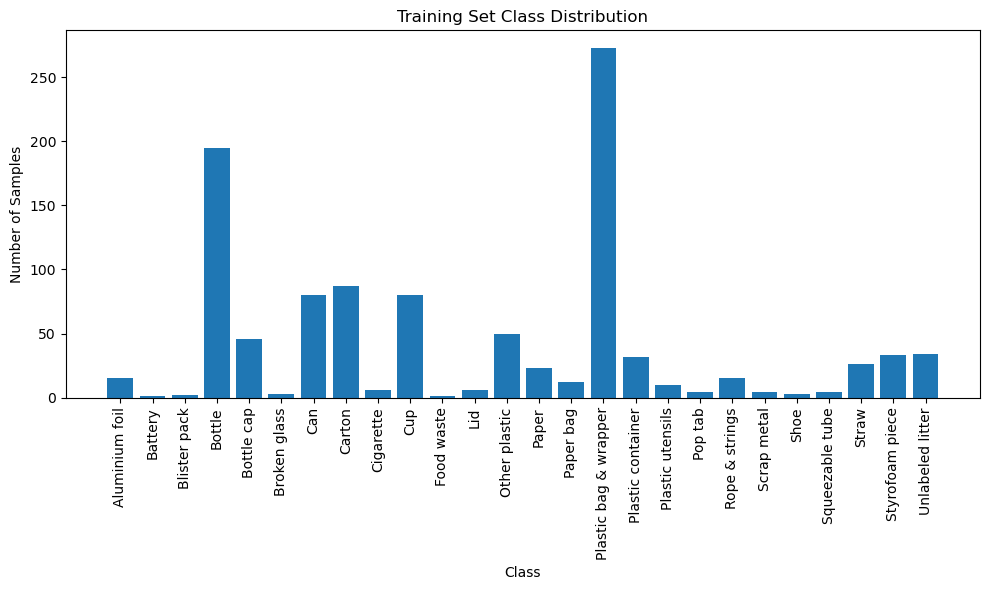

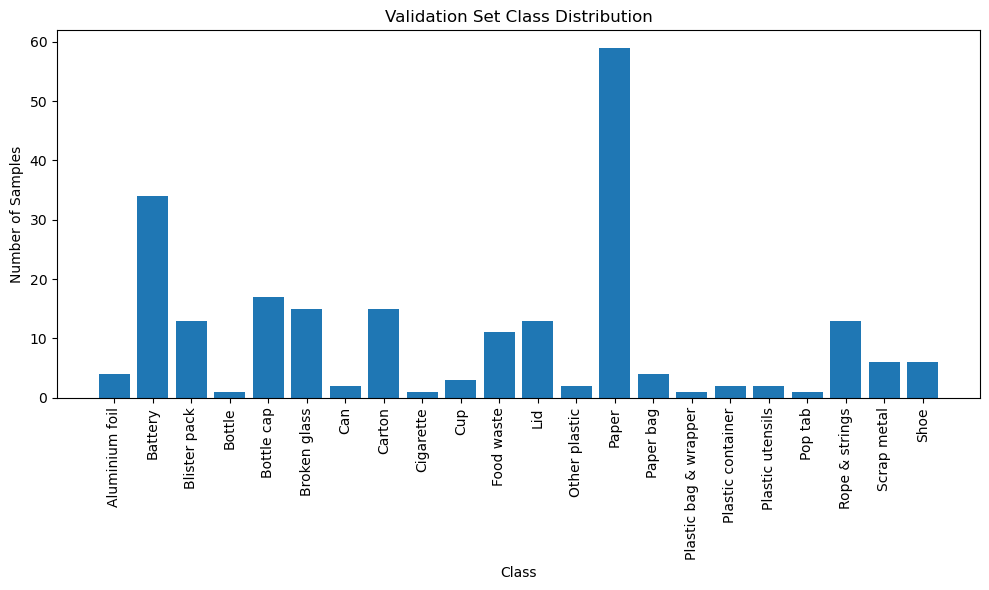

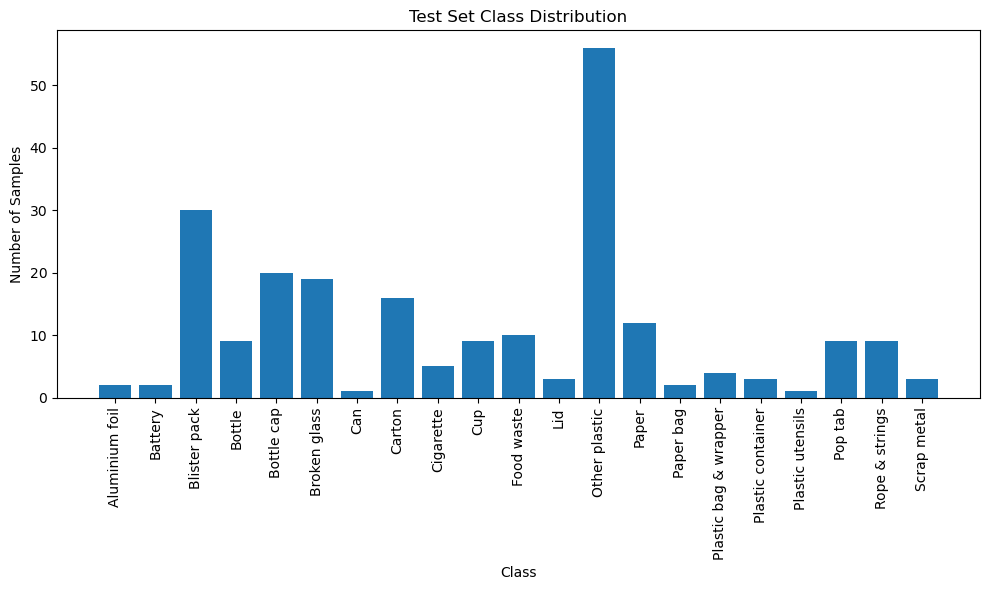

In [8]:
# Extract class counts from train, validation, and test sets
train_class_counts = Counter(train_data.classes)
val_class_counts = Counter(val_data.classes)
test_class_counts = Counter(test_data.classes)

# Map class indices back to class names
class_indices = {v: k for k, v in train_data.class_indices.items()}
train_class_counts_named = {class_indices[k]: v for k, v in train_class_counts.items()}
val_class_counts_named = {class_indices.get(k, f"Class {k}"): v for k, v in val_class_counts.items()}
test_class_counts_named = {class_indices.get(k, f"Class {k}"): v for k, v in test_class_counts.items()}

# Create histograms
def plot_histogram(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot histograms for train, validation, and test sets
plot_histogram(train_class_counts_named, "Training Set Class Distribution")
plot_histogram(val_class_counts_named, "Validation Set Class Distribution")
plot_histogram(test_class_counts_named, "Test Set Class Distribution")

In [9]:
def filter_classes(data_generator, classes_to_keep):
    """
    Filter out samples from a data generator where the class index is not in the classes_to_keep set.
    """
    filtered_indices = [
        i for i, class_idx in enumerate(data_generator.classes) if class_idx in classes_to_keep
    ]
    return Counter(data_generator.classes[i] for i in filtered_indices)

In [10]:
# Ensure train_data is defined (placeholder here)
try:
    train_class_counts = Counter(train_data.classes)
except NameError:
    print("Please reinitialize train_data, val_data, and test_data.")

# Identify classes to keep
classes_to_keep = {class_idx for class_idx, count in train_class_counts.items() if count >= 7}

In [11]:
# Filter train, val, and test data
filtered_train_class_counts = filter_classes(train_data, classes_to_keep)
filtered_val_class_counts = filter_classes(val_data, classes_to_keep)
filtered_test_class_counts = filter_classes(test_data, classes_to_keep)

# Map class indices back to names for visualization
class_indices = {v: k for k, v in train_data.class_indices.items()}
filtered_train_class_counts_named = {
    class_indices[k]: v for k, v in filtered_train_class_counts.items()
}
filtered_val_class_counts_named = {
    class_indices[k]: v for k, v in filtered_val_class_counts.items()
}
filtered_test_class_counts_named = {
    class_indices[k]: v for k, v in filtered_test_class_counts.items()
}



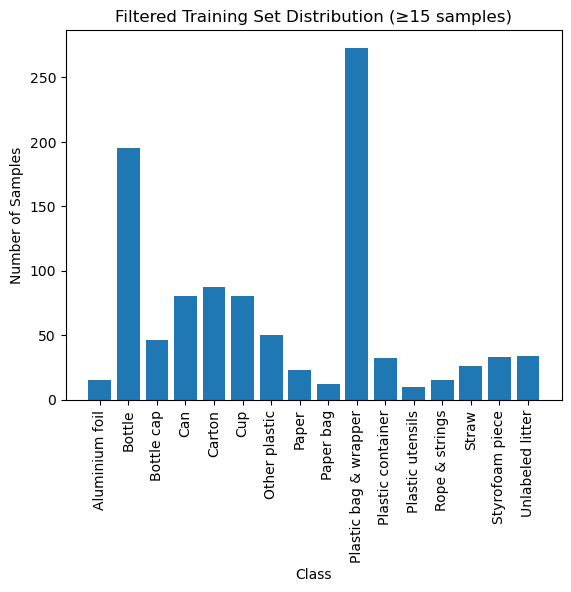

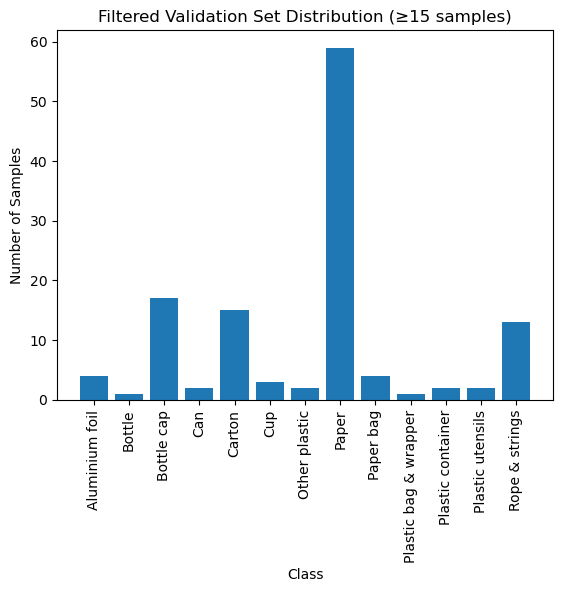

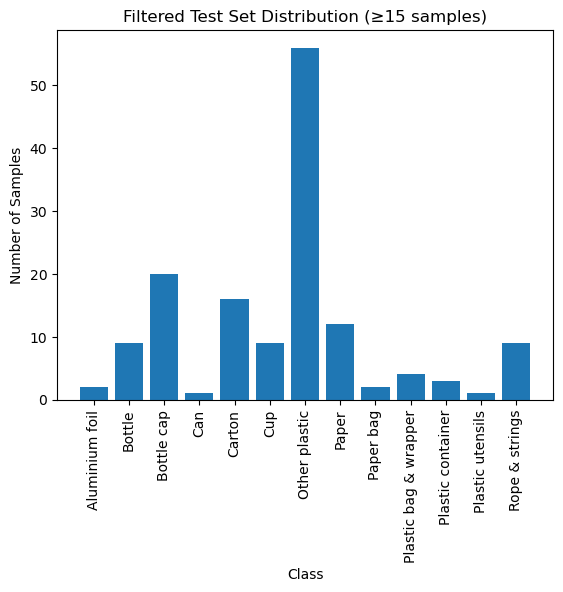

({'Aluminium foil': 15,
  'Bottle': 195,
  'Bottle cap': 46,
  'Can': 80,
  'Carton': 87,
  'Cup': 80,
  'Other plastic': 50,
  'Paper': 23,
  'Paper bag': 12,
  'Plastic bag & wrapper': 273,
  'Plastic container': 32,
  'Plastic utensils': 10,
  'Rope & strings': 15,
  'Straw': 26,
  'Styrofoam piece': 33,
  'Unlabeled litter': 34},
 {'Aluminium foil': 4,
  'Bottle': 1,
  'Bottle cap': 17,
  'Can': 2,
  'Carton': 15,
  'Cup': 3,
  'Other plastic': 2,
  'Paper': 59,
  'Paper bag': 4,
  'Plastic bag & wrapper': 1,
  'Plastic container': 2,
  'Plastic utensils': 2,
  'Rope & strings': 13},
 {'Aluminium foil': 2,
  'Bottle': 9,
  'Bottle cap': 20,
  'Can': 1,
  'Carton': 16,
  'Cup': 9,
  'Other plastic': 56,
  'Paper': 12,
  'Paper bag': 2,
  'Plastic bag & wrapper': 4,
  'Plastic container': 3,
  'Plastic utensils': 1,
  'Rope & strings': 9})

In [12]:
# Plot filtered distributions
def plot_filtered_distribution(class_counts_named, title):
    plt.bar(class_counts_named.keys(), class_counts_named.values())
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_filtered_distribution(filtered_train_class_counts_named, "Filtered Training Set Distribution (≥15 samples)")
plot_filtered_distribution(filtered_val_class_counts_named, "Filtered Validation Set Distribution (≥15 samples)")
plot_filtered_distribution(filtered_test_class_counts_named, "Filtered Test Set Distribution (≥15 samples)")

(filtered_train_class_counts_named, filtered_val_class_counts_named, filtered_test_class_counts_named)

In [13]:
for dataset_dir in [train_dir, val_dir, test_dir]:
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir) and not os.listdir(class_dir):
            os.rmdir(class_dir)  # Remove the empty directory
            print(f"Removed empty directory: {class_dir}")


Removed empty directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Battery
Removed empty directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Blister pack
Removed empty directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Food waste
Removed empty directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Pop tab
Removed empty directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Shoe
Removed empty directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Squeezable tube
Removed empty directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Battery
Removed empty directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Broken glass
Removed empty directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Food waste
Removed empty directory: C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Pop tab
Removed empty directory: C:\Users\b

In [14]:
train_classes = set(os.listdir(train_dir))
val_classes = set(os.listdir(val_dir))
test_classes = set(os.listdir(test_dir))

# Find and remove mismatched classes
for dataset, dataset_classes in [("val", val_classes), ("test", test_classes)]:
    for cls in dataset_classes - train_classes:
        print(f"Removing {cls} from {dataset} as it's not in training classes.")
        shutil.rmtree(os.path.join(val_dir if dataset == "val" else test_dir, cls))


Removing Glass jar from val as it's not in training classes.
Removing Plastic glooves from val as it's not in training classes.
Removing Plastic glooves from test as it's not in training classes.
